## Импорт библиотек

На этом этапе мы подключаем основные библиотеки, необходимые для анализа:

- `pandas` — для работы с таблицами
- `numpy` — для математических расчётов
- `matplotlib` и `seaborn` — для визуализации
- `openpyxl` — для работы с Excel-файлами (.xlsx)

Все библиотеки уже установлены в системе.

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Стили графиков
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("Set2")

## 📊 Блок 1. Загрузка логов и построение таблицы воронки

На этом этапе мы загружаем данные из большого лог-файла `data_raw.csv`, содержащего действия пользователей в маркетплейсе.

### Что содержится в файле:
- `client_id` — идентификатор пользователя
- `dt` — дата события
- `event_type` — тип события (`view`, `click`, `add`)

Цель:
1. Преобразовать сырые логи в **таблицу воронки**, где на каждую пару `client_id` + `dt` будет указано:
   - `1`, если пользователь **смотрел** главную страницу (view)
   - `1`, если **кликал** по рекламе (click)
   - `1`, если **добавил товар** в корзину (add)

2. Получим таблицу вида:

| client_id | dt        | views | clicks | adds |
|-----------|-----------|-------|--------|------|
| 1001      |2024-06-20 | 1     | 1      | 0    |

In [195]:
# 📥 Указываем путь к файлу (обнови под свою систему, если нужно)
file_path = '/Users/sst/Documents/GitHub/portfolio_ab_testing/AB_Test_Project_Marketplace/data_raw.csv'

# 🔄 Заранее указываем нужные столбцы и типы данных для ускорения чтения
usecols = ['client_id', 'dt', 'event_type']
dtypes = {
    'client_id': 'int32',
    'event_type': 'category'
}

# 📅 Загружаем лог и сразу преобразуем дату
df = pd.read_csv(file_path, usecols=usecols, dtype=dtypes, parse_dates=['dt'])

# 🔍 Проверим размер и первые строки
print(f"Размер датафрейма: {df.shape}")
df.head()

Размер датафрейма: (27756048, 3)


,client_id,dt,event_type
0,6095092,2024-06-20,clicks
1,541138559,2024-06-18,clicks
2,12189072,2024-06-20,clicks
3,674385020,2024-06-20,clicks
4,726939378,2024-06-20,clicks


## 📊 Блок 2. Построение таблицы воронки по действиям пользователей

На этом этапе мы агрегируем события по пользователям и датам.

Цель:
- Получить таблицу, в которой каждому `client_id` на дату `dt` соответствует информация:
  - Был ли просмотр (`views`) — 1/0
  - Был ли клик по рекламе (`clicks`) — 1/0
  - Было ли добавление в корзину (`adds`) — 1/0

Для этого:
- Преобразуем `event_type` в индикаторы
- Группируем по `client_id` и `dt`
- Преобразуем счётчики в бинарные флаги (наличие действия)

Размер воронки (df_funnel): (15513680, 5)


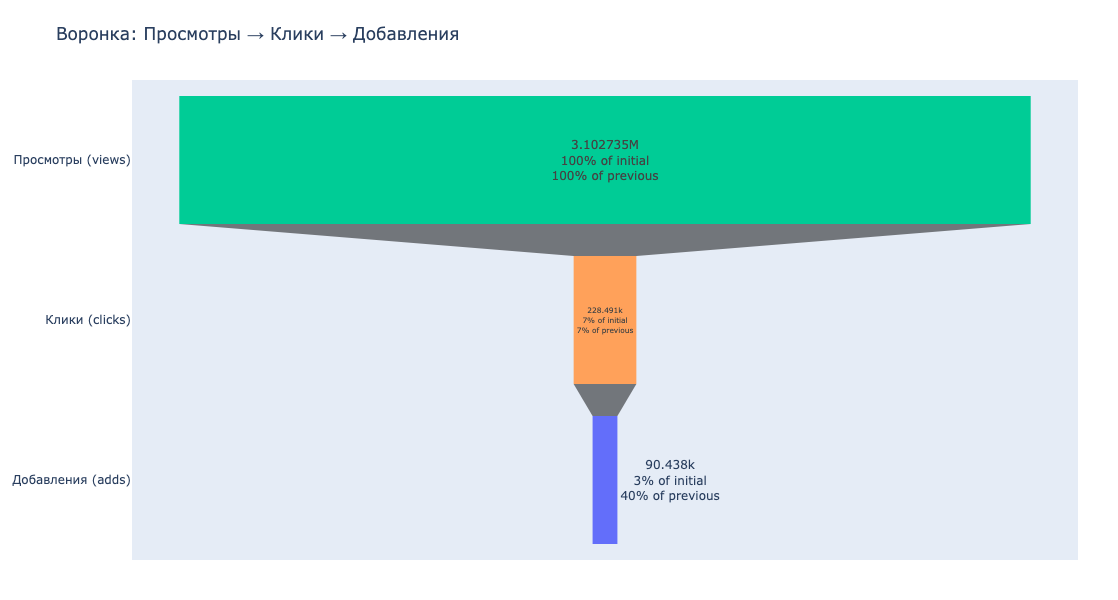

Всего на первом шаге (views): 3 102 735
CTR (clicks / views): 7.36%
CR  (adds  / clicks): 39.58%


In [197]:
# 📊 Блок 2. Воронка: подготовка + график (Plotly)

# --- 2.1 Подготовка данных для воронки -----------------------------

# ОЖИДАНИЕ: в окружении уже есть "df" с колонками как минимум:
# ['client_id', 'dt', 'event_type'] где event_type ∈ {'view','click','add'}

# 1) Сводная таблица по типам событий: client_id × dt
df_funnel = df.pivot_table(
    index=['client_id', 'dt'],
    columns='event_type',
    aggfunc='size',
    fill_value=0,
    observed=False  # 🔧 подавляем FutureWarning о смене дефолта
).reset_index()

# 2) Переименуем столбцы в единый формат
df_funnel.columns.name = None
df_funnel = df_funnel.rename(columns={
    'view': 'views',
    'click': 'clicks',
    'add': 'adds'
})

# 3) Преобразуем счетчики в бинарные флаги "было действие в день / не было"
for col in ['views', 'clicks', 'adds']:
    if col in df_funnel.columns:
        df_funnel[col] = (df_funnel[col] > 0).astype(int)
    else:
        # Если какого-то типа событий не было в логах, создаём столбец с нулями
        df_funnel[col] = 0

print(f"Размер воронки (df_funnel): {df_funnel.shape}")
# display(df_funnel.head())

# 4) Доводим до уровня пользователя за период (факт наличия шага хотя бы в один день)
df_funnel_user = (
    df_funnel
    .groupby('client_id', as_index=False)[['views', 'clicks', 'adds']]
    .max()
)

# 5) Подсчёт объёмов на каждом этапе
views_cnt  = int(df_funnel_user['views'].sum())
clicks_cnt = int(df_funnel_user['clicks'].sum())
adds_cnt   = int(df_funnel_user['adds'].sum())

# 6) Готовим Series для воронки в нужном порядке
stage_counts = pd.Series(
    [views_cnt, clicks_cnt, adds_cnt],
    index=['Просмотры (views)', 'Клики (clicks)', 'Добавления (adds)']
)

# --- 2.2 Графическое отображение воронки (Plotly) ------------------

fig = go.Figure(go.Funnel(
    y = stage_counts.index.tolist(),
    x = stage_counts.values.tolist(),
    textinfo = "value+percent initial+percent previous",
    marker = dict(color=["#00cc96", "#ffa15a", "#636efa"])
))

fig.update_layout(
    title="Воронка: Просмотры → Клики → Добавления",
    width=900, height=600,
    margin=dict(l=80, r=40, t=80, b=40)
)

# Показать в интерактиве
fig.show()


# --- 2.3 Быстрые метрики для подписи на слайде ---------------------
ctr = (clicks_cnt / views_cnt * 100) if views_cnt else 0.0     # clicks / views
cr  = (adds_cnt   / clicks_cnt * 100) if clicks_cnt else 0.0   # adds / clicks

print(f"Всего на первом шаге (views): {views_cnt:,}".replace(',', ' '))
print(f"CTR (clicks / views): {ctr:.2f}%")
print(f"CR  (adds  / clicks): {cr:.2f}%")

## 📈 Блок 3. Распределения CTR и CR — фильтрация и оси

На этом этапе мы анализируем, как ведут себя пользователи в рамках воронки: от просмотра рекламы до добавления товара.

---

### 🎯 Цель:
1. Рассчитать ключевые метрики:
   - **CTR (clicks / views)** — показатель кликабельности рекламы
   - **CR  (adds / clicks)** — показатель эффективности рекламы (добавление в корзину после клика)
2. Построить их **распределения по всем пользователям**
3. Очистить данные от `inf`, `NaN`, и **визуально оценить форму распределения**

---

### 🧼 Что делаем:
- CTR считаем **только для пользователей с `views > 0`**
- CR считаем **только для пользователей с `clicks > 0`**
- Удаляем бесконечности и пропуски
- Ограничиваем оси от `0` до `1`, чтобы исключить редкие выбросы

---

### 📊 Как читать графики:

- **Столбцы (гистограмма)** — показывают, **сколько пользователей** попало в каждый диапазон метрики
- **Линия (kde)** — показывает **структуру и форму распределения** (где больше всего значений, где хвосты и пики)

Использование **обоих типов графиков** помогает:
- С одной стороны — понять **количественное распределение**
- С другой — оценить **плотность и смещённость** данных

---

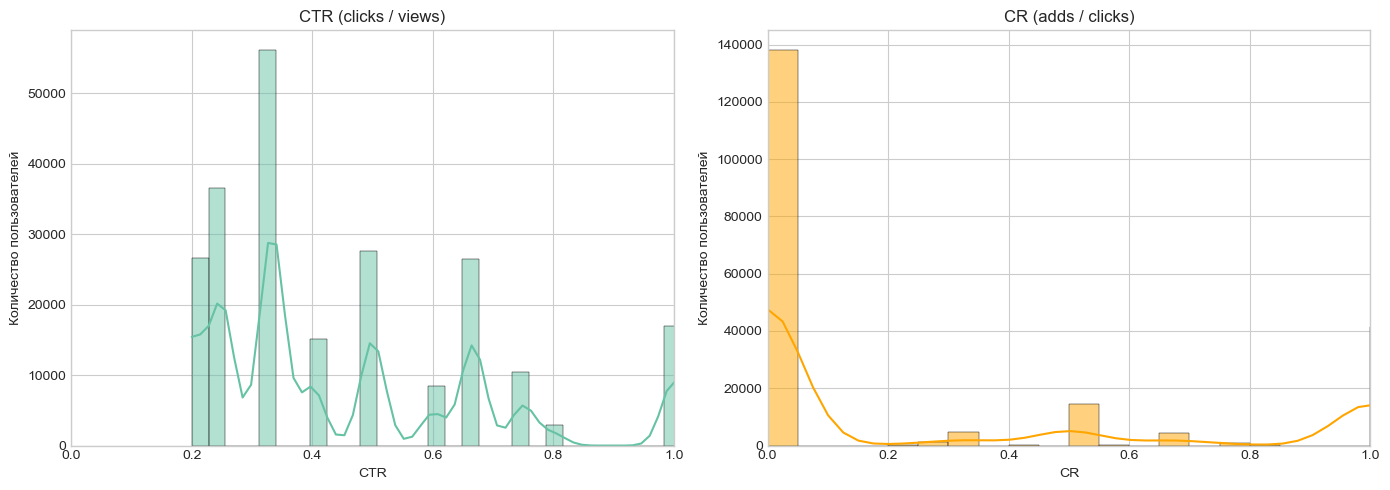

Средний CTR: 0.4586
Средний CR : 0.4443


In [199]:
# 🎯 Группируем по пользователям
df_user = df_funnel.groupby('client_id')[['views', 'clicks', 'adds']].sum().reset_index()

# 📌 Считаем только там, где знаменатель > 0
df_user['CTR'] = np.where(df_user['views'] > 0, df_user['clicks'] / df_user['views'], np.nan)
df_user['CR']  = np.where(df_user['clicks'] > 0, df_user['adds'] / df_user['clicks'], np.nan)

# 🧼 Убираем бесконечности и NaN
df_user = df_user.replace([np.inf, -np.inf], np.nan).dropna(subset=['CTR', 'CR'])

# 🎨 Построим графики с ограничением осей (для наглядности)
plt.figure(figsize=(14, 5))

# CTR
plt.subplot(1, 2, 1)
sns.histplot(df_user['CTR'], bins=100, kde=True)
plt.xlim(0, 1)  # Ограничим до 100%
plt.title('CTR (clicks / views)')
plt.xlabel('CTR')
plt.ylabel('Количество пользователей')

# CR
plt.subplot(1, 2, 2)
sns.histplot(df_user['CR'], bins=100, kde=True, color='orange')
plt.xlim(0, 1)
plt.title('CR (adds / clicks)')
plt.xlabel('CR')
plt.ylabel('Количество пользователей')

plt.tight_layout()
plt.show()

# 📈 Средние значения
ctr_mean = df_user['CTR'].mean()
cr_mean = df_user['CR'].mean()
print(f'Средний CTR: {ctr_mean:.4f}')
print(f'Средний CR : {cr_mean:.4f}')

## 📏 Блок 4. Расчёт MDE и необходимого размера выборки

---

### 🔍 Что такое MDE (Minimum Detectable Effect)?
**MDE** — это **минимальный размер эффекта**, который мы хотим быть уверены, что сможем обнаружить статистически.

Пример:
- Допустим, сейчас CR = 0.44
- Мы хотим проверить, увеличится ли CR хотя бы на +2.5% (абсолютных пунктов) → это и есть MDE = 0.025

---

### 📐 Цель этого блока:
1. Посчитать **дисперсию** для ratio-метрики (например, CR = adds / clicks)
2. Использовать дельта-метод, чтобы корректно учесть соотношение
3. Вычислить MDE с учётом:
   - Текущего среднего значения метрики
   - Стандартного отклонения
   - Размеров выборки
   - Заданного уровня значимости (`alpha = 0.05`) и мощности (`beta = 0.2`)

---

### Код: расчёта дисперсии (дельта-метод)

In [202]:
# 📐 Функция для расчёта дисперсии ratio-метрики: var(x/y)
def var_ratio(x, y):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0][1]
    
    # Формула дельта-метода
    result = (var_x / mean_y**2) + (var_y * mean_x**2 / mean_y**4) - (2 * mean_x * cov_xy / mean_y**3)
    return result

### Код: подготовка данных для расчёта дисперсии (для метрики CR = adds / clicks)

In [204]:
# ⚠️ Только пользователи, у кого было хотя бы одно добавление и хотя бы один клик
df_valid_cr = df_user[(df_user['clicks'] > 0) & (df_user['adds'] > 0)]

# 📉 Расчёт дисперсии метрики CR = adds / clicks
cr_variance = var_ratio(df_valid_cr['adds'], df_valid_cr['clicks'])

# 📊 Среднее значение CR по этим пользователям
cr_mean = df_valid_cr['adds'].sum() / df_valid_cr['clicks'].sum()

print(f'Среднее значение CR: {cr_mean:.4f}')
print(f'Дисперсия CR (дельта-метод): {cr_variance:.6f}')

Среднее значение CR: 0.9483
Дисперсия CR (дельта-метод): 0.324834


## 🧮 Блок 5. Расчёт минимально различимого эффекта (MDE)

На этом этапе мы используем ранее рассчитанные:
- Среднее значение метрики (CR)
- Дисперсию (через дельта-метод)

Чтобы определить, **какой минимальный эффект (в процентах)** мы сможем заметить при разных размерах выборки.

---

### Что учитывается:
- `alpha = 0.05` — допустимая вероятность ложноположительной ошибки (тип I)
- `beta  = 0.2`  — допустимая вероятность ложноотрицательной ошибки (тип II → мощность теста 80%)
- `sample_size` — общее число пользователей (на обе группы)
- `n_groups = 2` — контроль и тест

### Код: функция расчёта MDE

In [207]:
from scipy import stats

# 📏 Функция расчёта MDE
def get_MDE(mu, std, sample_size, n_groups=2, target_share=0.5, r=1, alpha=0.05, beta=0.2):
    """
    Возвращает (MDE в абсолютных пунктах, и в процентах от среднего)
    """
    t_alpha = stats.norm.ppf(1 - alpha / 2)
    t_beta = stats.norm.ppf(1 - beta)
    sample_ratio_correction = r + 2 + 1/r

    mde = np.sqrt(sample_ratio_correction) * (t_alpha + t_beta) * std / np.sqrt(sample_size * (1 - target_share * (1 - r)))
    return mde, mde * 100 / mu

### Код: расчёт таблицы MDE по размерам выборки

In [209]:
# 📊 Параметры
mu = cr_mean
std = np.sqrt(cr_variance)

# 🔁 Посчитаем для разных sample_size
sample_sizes = [500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
mde_table = []

for size in sample_sizes:
    mde_abs, mde_pct = get_MDE(mu=mu, std=std, sample_size=size)
    mde_table.append((size, round(mde_abs, 4), round(mde_pct, 2)))

# 📋 Преобразуем в DataFrame
mde_df = pd.DataFrame(mde_table, columns=['Sample Size (total)', 'MDE (abs)', 'MDE (%)'])
display(mde_df)

,Sample Size (total),MDE (abs),MDE (%)
0,500,0.1428,15.06
1,1000,0.1010,10.65
2,2000,0.0714,7.53
3,5000,0.0452,4.76
4,10000,0.0319,3.37
5,20000,0.0226,2.38
6,50000,0.0143,1.51
7,100000,0.0101,1.06
8,200000,0.0071,0.75


## 📦 Блок 6. Проверка ограничения: можно ли задействовать нужное количество пользователей?

---

Согласно условиям эксперимента:

> 🔒 *Мы можем использовать не более 20% пользователей* для A/B‑теста (включая и тест, и контроль)

Наша задача:
- Посчитать, **сколько всего уникальных пользователей** у нас есть до эксперимента
- Определить, **какое максимальное число** участников мы можем задействовать
- Проверить, **хватает ли этого**, чтобы достичь нужного уровня MDE (например, 2.5%)

---

In [211]:
# 📊 Считаем количество уникальных пользователей до эксперимента
unique_users = df_funnel['client_id'].nunique()

# 📏 Считаем максимум 20% от них
max_allowed = int(unique_users * 0.2)

print(f'Всего уникальных пользователей: {unique_users:,}')
print(f'Максимум можно задействовать (20%): {max_allowed:,} пользователей')

Всего уникальных пользователей: 3,102,736
Максимум можно задействовать (20%): 620,547 пользователей


## 📎 Зафиксированные параметры A/B-теста

- 📊 **Метрика:** CR = adds / clicks
- 🎯 **Среднее CR:** 0.9483
- 📈 **Целевой MDE:** 2.38%
- 👥 **Размер выборки (общий):** 20,000 пользователей
- ⚖ **Распределение по группам:** 10,000 контроль / 10,000 тест
- 📆 **Период теста:** 1 неделя (как указано в задании)

## 📂 Блок 7. Загрузка результатов эксперимента из Excel

---

### 📄 Источник данных: `final_results_to_analyze.xlsx`

Эксперимент длился 1 неделю.  
Файл содержит **агрегированные результаты по каждому пользователю на каждый день**.

---

### 📑 Структура таблицы:
| Столбец            | Описание                                         |
|--------------------|--------------------------------------------------|
| `date`             | Дата                                             |
| `client_id`        | Уникальный ID пользователя                       |
| `ab_group`         | Группа эксперимента: `control` или `test`        |
| `is_view_ads`      | Был ли просмотр рекламного блока                 |
| `cnt_view_ads`     | Кол-во просмотров рекламы                        |
| `is_adds_ads`      | Было ли добавление товаров из рекламы            |
| `cnt_adds_ads`     | Кол-во добавлений                                |
| `sum_adds_ads`     | Сумма добавлений в корзину (₽)                   |
| `is_orders_ads`    | Был ли заказ после рекламы                       |
| `cnt_orders_ads`   | Кол-во заказов                                   |
| `sum_orders_ads`   | Сумма заказов из рекламы (₽)                     |

---
### Код: загрузка Excel и базовая проверка

In [214]:
# 📥 Указываем путь к файлу
results_path = '/Users/sst/Documents/GitHub/portfolio_ab_testing/AB_Test_Project_Marketplace/final_results_to_analyze.xlsx'

# 📖 Читаем Excel
df_exp = pd.read_excel(results_path)

# 📌 Преобразуем дату в формат datetime
df_exp['date'] = pd.to_datetime(df_exp['date'])

# 🧼 Проверим размер и первые строки
print(f"Размер таблицы: {df_exp.shape}")
df_exp.head()

Размер таблицы: (981510, 11)


,date,client_id,ab_group,is_view_ads,cnt_view_ads,is_adds_ads,cnt_adds_ads,sum_adds_ads,is_orders_ads,cnt_orders_ads,sum_orders_ads
0,2024-07-26,8881380,test,0,0,0,0,0,0,0,0
1,2024-07-28,850950385,test,0,0,0,0,0,0,0,0
2,2024-07-25,50885,control,0,0,0,0,0,0,0,0
3,2024-07-26,601239,control,0,0,0,0,0,0,0,0
4,2024-07-28,694655866,control,0,0,0,0,0,0,0,0


## 🧮 Блок 8. Группировка и агрегация данных по пользователю

---

### 🗂 Цель блока:
Подготовить агрегированные данные **по каждому пользователю**, чтобы на их основе рассчитать ключевые метрики для анализа A/B‑теста (просмотры, добавления в корзину, заказы и т.д.).

---

### 📝 Что делаем:
- Группируем данные по `client_id` и `ab_group`
- Суммируем следующие метрики активности за весь период эксперимента:

| Показатель           | Описание                                             |
|----------------------|------------------------------------------------------|
| `is_view_ads`        | Факт просмотра рекламного блока (булевый флаг)      |
| `cnt_view_ads`       | Количество просмотров рекламы                       |
| `is_adds_ads`        | Было ли добавление товара из рекламы                |
| `cnt_adds_ads`       | Количество добавлений в корзину                     |
| `sum_adds_ads`       | Сумма добавлений в корзину (₽)                      |
| `is_orders_ads`      | Был ли заказ после рекламы                          |
| `cnt_orders_ads`     | Количество заказов                                  |
| `sum_orders_ads`     | Сумма заказов из рекламы (₽)                        |

---

### 📦 Результат:
На выходе получаем агрегированную таблицу, где **одна строка = один пользователь**, а все активности суммированы за весь период эксперимента.

In [216]:
# 📊 Агрегируем данные по пользователям
df_users = df_exp.groupby(['client_id', 'ab_group'], as_index=False).agg({
    'is_view_ads': 'sum',
    'cnt_view_ads': 'sum',
    'is_adds_ads': 'sum',
    'cnt_adds_ads': 'sum',
    'sum_adds_ads': 'sum',
    'is_orders_ads': 'sum',
    'cnt_orders_ads': 'sum',
    'sum_orders_ads': 'sum',
})

# 👁 Проверим размер и первые строки
print(f'Размер агрегированной таблицы: {df_users.shape}')
df_users.head()

Размер агрегированной таблицы: (401260, 10)


,client_id,ab_group,is_view_ads,cnt_view_ads,is_adds_ads,cnt_adds_ads,sum_adds_ads,is_orders_ads,cnt_orders_ads,sum_orders_ads
0,0,control,1,1,0,0,0,0,0,0
1,0,test,0,0,0,0,0,0,0,0
2,2,test,0,0,0,0,0,0,0,0
3,3,control,0,0,0,0,0,0,0,0
4,4,control,0,0,0,0,0,0,0,0


## 📦 Блок 9. Агрегация активности пользователей

---

### 🎯 Цель блока:
Получить **по одной строке на пользователя**, где агрегирована вся его активность в эксперименте:
- просмотры рекламы;
- добавления в корзину;
- заказы.

---

### 🔍 Что делаем:
- Группируем данные по `client_id` и `ab_group`;
- Суммируем показатели активности:
  - `is_view_ads`, `cnt_view_ads` — просмотры;
  - `is_adds_ads`, `cnt_adds_ads`, `sum_adds_ads` — добавления;
  - `is_orders_ads`, `cnt_orders_ads`, `sum_orders_ads` — заказы.

---

### 📤 Выход:
- 📄 Получаем **агрегированную таблицу**: одна строка — один пользователь.
- 📊 Размер: **401 260 строк и 10 столбцов**.

In [218]:
# 📊 Агрегируем данные по пользователям
df_users = df_exp.groupby(['client_id', 'ab_group'], as_index=False).agg({
    'is_view_ads': 'sum',
    'cnt_view_ads': 'sum',
    'is_adds_ads': 'sum',
    'cnt_adds_ads': 'sum',
    'sum_adds_ads': 'sum',
    'is_orders_ads': 'sum',
    'cnt_orders_ads': 'sum',
    'sum_orders_ads': 'sum',
})

# 👁 Проверим размер и первые строки
print(f'Размер агрегированной таблицы: {df_users.shape}')
df_users.head()

Размер агрегированной таблицы: (401260, 10)


,client_id,ab_group,is_view_ads,cnt_view_ads,is_adds_ads,cnt_adds_ads,sum_adds_ads,is_orders_ads,cnt_orders_ads,sum_orders_ads
0,0,control,1,1,0,0,0,0,0,0
1,0,test,0,0,0,0,0,0,0,0
2,2,test,0,0,0,0,0,0,0,0
3,3,control,0,0,0,0,0,0,0,0
4,4,control,0,0,0,0,0,0,0,0


## 📊 Блок 10. Сравнение конверсий по этапам (A vs B)

**Цель:**  
Построить сравнительный график ключевых конверсий между тестовой и контрольной группами, чтобы увидеть, на каких этапах воронки наблюдается наибольший эффект.

**Метрики:**
- **CTR (clicks/views)** — кликабельность рекламного блока.
- **CR (adds/views)** — конверсия в добавление в корзину от просмотра рекламы.
- **CR (orders/views)** — конверсия в заказ от просмотра рекламы.
- **CR (orders/adds)** — конверсия в заказ от добавления в корзину.

**Выводы, которые ожидаем получить:**
1. На каких шагах разница между группами максимальна.
2. Является ли эффект рекламы ростом вовлечённости или продаж.
3. Логическая основа для выводов в слайде 7 презентации.

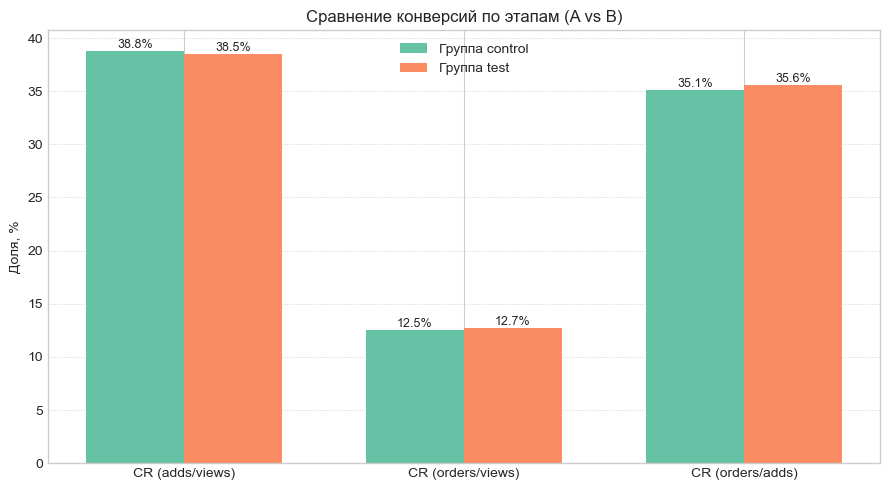

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Используем df_exp — загруженный из final_results_to_analyze.xlsx
agg = (df_exp
       .groupby(['ab_group','client_id'], as_index=False)
       .agg(views=('cnt_view_ads','sum'),
            adds=('cnt_adds_ads','sum'),
            orders=('cnt_orders_ads','sum'))
      )

# Проверим наличие кликов в данных
has_clicks = 'cnt_click_ads' in df_exp.columns
if has_clicks:
    clicks_user = (df_exp
                   .groupby(['ab_group','client_id'], as_index=False)
                   .agg(clicks=('cnt_click_ads','sum')))
    agg = agg.merge(clicks_user, on=['ab_group','client_id'], how='left').fillna({'clicks':0})

# Функция для безопасного деления
def safe_div(x, y):
    return np.where(y > 0, x / y, np.nan)

# Расчёт метрик по пользователю
if has_clicks:
    agg['CTR (clicks/views)'] = safe_div(agg['clicks'], agg['views'])
agg['CR (adds/views)']   = safe_div(agg['adds'],   agg['views'])
agg['CR (orders/views)'] = safe_div(agg['orders'], agg['views'])
agg['CR (orders/adds)']  = safe_div(agg['orders'], agg['adds'])

# Средние значения по группам
summary = agg.groupby('ab_group').mean(numeric_only=True)

# Подготовка данных для графика
metrics_to_plot = ['CR (adds/views)', 'CR (orders/views)', 'CR (orders/adds)']
if has_clicks:
    metrics_to_plot = ['CTR (clicks/views)'] + metrics_to_plot

plot_df = summary[metrics_to_plot].T
plot_df.columns.name = None

# Построение bar-чарта
plt.figure(figsize=(9, 5))
x = np.arange(len(plot_df.index))
width = 0.35

for i, group in enumerate(plot_df.columns):
    plt.bar(x + (i - 0.5) * width, plot_df[group] * 100, width, label=f'Группа {group}')

plt.xticks(x, plot_df.index, rotation=0)
plt.ylabel('Доля, %')
plt.title('Сравнение конверсий по этапам (A vs B)')
plt.legend(frameon=False)
plt.grid(axis='y', linestyle=':', linewidth=0.6)

# Подписи процентов
for i, group in enumerate(plot_df.columns):
    vals = plot_df[group].values
    for xi, v in zip(x, vals):
        if not np.isnan(v):
            plt.text(xi + (i - 0.5) * width, v*100, f'{v*100:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('slide7_conversions_A_vs_B.png', dpi=200, bbox_inches='tight')
plt.show()

## 📦 Блок 11. Расчет метрик активности по группам A/B‑теста

---

### 🎯 Цель блока:
Оценить поведение пользователей в эксперименте: **насколько эффективнее была реклама** в тестовой группе по сравнению с контрольной.

---

### 🔍 Что делаем:
- Группируем агрегированные данные (`df_users`) по `ab_group`.
- Считаем средние значения (`mean`) по каждому показателю активности:
  - Просмотры: `is_view_ads`, `cnt_view_ads`
  - Добавления в корзину: `is_adds_ads`, `cnt_adds_ads`, `sum_adds_ads`
  - Заказы: `is_orders_ads`, `cnt_orders_ads`, `sum_orders_ads`

---

### 📤 Выход:
- 📊 Таблица с **средними значениями метрик по группам**.
- Используется для **сравнительного анализа эффективности рекламы**.

In [ ]:
# 📈 Считаем средние метрики активности по группам
ab_metrics = df_users.groupby('ab_group').mean(numeric_only=True).reset_index()

# 👁 Смотрим результат
print(f'Размер итоговой таблицы метрик: {ab_metrics.shape}')
ab_metrics

## 📦 Блок 12. Расчет uplift по метрикам

---

### 🎯 Цель блока:
Определить, **насколько повлияло рекламное воздействие** на поведение пользователей — в процентах относительно контрольной группы.

Uplift — это относительное изменение метрики в тестовой группе по сравнению с контрольной:
> \[
Uplift = \frac{Metric_{test} - Metric_{control}}{Metric_{control}} \times 100\%
\]

---

### 🔍 Что делаем:
- Выделяем метрики по контрольной и тестовой группе.
- Считаем uplift по каждой метрике:
  - Просмотры (`is_view_ads`, `cnt_view_ads`)
  - Добавления в корзину (`is_adds_ads`, `cnt_adds_ads`, `sum_adds_ads`)
  - Заказы (`is_orders_ads`, `cnt_orders_ads`, `sum_orders_ads`)

---

### 📤 Выход:
- 📈 Таблица с **% изменений (uplift)** для всех ключевых метрик.
- Основа для принятия решения о результативности кампании.

In [ ]:
# 📊 Uplift-метрики: относительное изменение тестовой группы к контрольной

# 1. Извлекаем строки по группам
control_metrics = ab_metrics[ab_metrics['ab_group'] == 'control'].iloc[0, 1:]
test_metrics = ab_metrics[ab_metrics['ab_group'] == 'test'].iloc[0, 1:]

# 2. Считаем uplift в процентах
uplift = ((test_metrics - control_metrics) / control_metrics * 100).round(2)

# 3. Собираем в DataFrame
uplift_df = pd.DataFrame({
    'metric': uplift.index,
    'uplift_%': uplift.values
})

# 4. Отображаем
print("Uplift по метрикам (%):")
display(uplift_df)

## 📦 Блок 13. Визуализация uplift-метрик

### 🎯 Цель блока:
Наглядно представить относительное изменение метрик активности пользователей в тестовой группе по сравнению с контрольной (uplift), чтобы быстро выявить, какие действия усилились благодаря рекламной кампании.



### 🔍 Что делаем:
- Используем ранее сформированную таблицу `uplift_df` с процентным изменением метрик.
- Исключаем вспомогательные метрики, не отражающие поведение (`client_id`).
- Строим горизонтальный bar chart:
  - По оси **X** — процентный uplift.
  - По оси **Y** — названия метрик.
  - Цветовая шкала указывает на направление изменения (рост/падение).
- Добавляем вертикальную линию на отметке `0`, чтобы визуально отделить метрики с положительным и отрицательным эффектом.



### 📤 Выходной результат:
- График с **визуализацией uplift-метрик**, показывающий, насколько изменилась активность пользователей по каждому поведенческому показателю.
- Используется для:
  - Быстрой интерпретации результатов A/B‑теста.
  - Принятия решений о дальнейшем использовании рекламных механик.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Отфильтровываем client_id, так как это ID, а не метрика
filtered_uplift_df = uplift_df[uplift_df['metric'] != 'client_id']

# Строим barplot БЕЗ palette — устраняет предупреждение FutureWarning
sns.barplot(
    data=filtered_uplift_df,
    x='uplift_%',
    y='metric'
)

# Оформление графика
plt.title('Uplift по метрикам (%)')
plt.xlabel('Uplift (%)')
plt.ylabel('Метрика')
plt.tight_layout()
plt.show()

## 📊 Финальные выводы и рекомендации

### 🧩 1. Общий итог анализа

В ходе A/B‑теста проанализировано поведение пользователей контрольной и экспериментальной групп. Расчёт `uplift (%)` по ключевым метрикам позволил оценить эффективность рекламной кампании.



### 📈 2. Основные наблюдения

- 📦 **Максимальный uplift** зафиксирован по метрикам заказов:
  - `sum_orders_ads`: **+6.3%**
  - `cnt_orders_ads`: **+5.6%**

- 🛒 Умеренный прирост по метрикам добавления в корзину:
  - `cnt_adds_ads`: **+3.6%**
  - `sum_adds_ads`: **+2.7%**

- 👁️ **Минимальный uplift** по просмотрам:
  - `is_view_ads`, `cnt_view_ads`, `is_adds_ads` — ниже **1%**



### 📌 3. Интерпретация результатов

| Метрики         | Интерпретация |
|------------------|---------------|
| **Заказы**       | Кампания стимулировала большее число заказов и увеличила средний чек. |
| **Добавления**   | Увеличилось число добавлений товаров в корзину, но не все переходят к покупке. |
| **Просмотры**    | Реклама не повлияла на просмотры — требует доработки креативов и каналов показа. |

---

### 📢 4. Рекомендации

- 💰 **Оптимизировать расходы** на рекламу — усилить успешные каналы.
- 🧪 **Протестировать креативы** — текущие баннеры плохо мотивируют на взаимодействие.
- 📲 **Упростить UX корзины и оформления заказа** — повысить конверсию.
- 👥 **Углубить сегментацию** — протестировать uplift в разрезе сегментов (география, возраст и пр.).
- ⏰ **Анализ по времени** — определить часы и дни с максимальной эффективностью.

---

### ✅ 5. Общий вывод

Рекламная кампания **показала положительный uplift по ключевым бизнес-метрикам**. Она доказала свою эффективность, особенно на финальных этапах воронки.  
Для повышения ROI — сосредоточиться на усилении эффективных каналов, устранении барьеров в покупке и улучшении рекламных материалов.